In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

#Load dataset
df = pd.read_csv("../data/marketing_campaign.csv", delimiter="\t")


df = df.dropna()

df.head()


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


Exploratory data analysis

In [2]:
df = df.drop(columns=[
    # spending columns
    "MntWines","MntFruits","MntMeatProducts","MntFishProducts",
    "MntSweetProducts","MntGoldProds",

    # campaign acceptances (leakage)
    "AcceptedCmp1","AcceptedCmp2","AcceptedCmp3",
    "AcceptedCmp4","AcceptedCmp5",

    # useless/system columns
    "Z_CostContact","Z_Revenue",

    # IDs, date
    "ID","Dt_Customer"
])


In [3]:
df["Target"] = df["Response"]
df = df.drop(columns=["Response"])


In [4]:
df.info()
df.describe()
df["Target"].value_counts()

<class 'pandas.core.frame.DataFrame'>
Index: 2216 entries, 0 to 2239
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2216 non-null   int64  
 1   Education            2216 non-null   object 
 2   Marital_Status       2216 non-null   object 
 3   Income               2216 non-null   float64
 4   Kidhome              2216 non-null   int64  
 5   Teenhome             2216 non-null   int64  
 6   Recency              2216 non-null   int64  
 7   NumDealsPurchases    2216 non-null   int64  
 8   NumWebPurchases      2216 non-null   int64  
 9   NumCatalogPurchases  2216 non-null   int64  
 10  NumStorePurchases    2216 non-null   int64  
 11  NumWebVisitsMonth    2216 non-null   int64  
 12  Complain             2216 non-null   int64  
 13  Target               2216 non-null   int64  
dtypes: float64(1), int64(11), object(2)
memory usage: 259.7+ KB


Target
0    1883
1     333
Name: count, dtype: int64

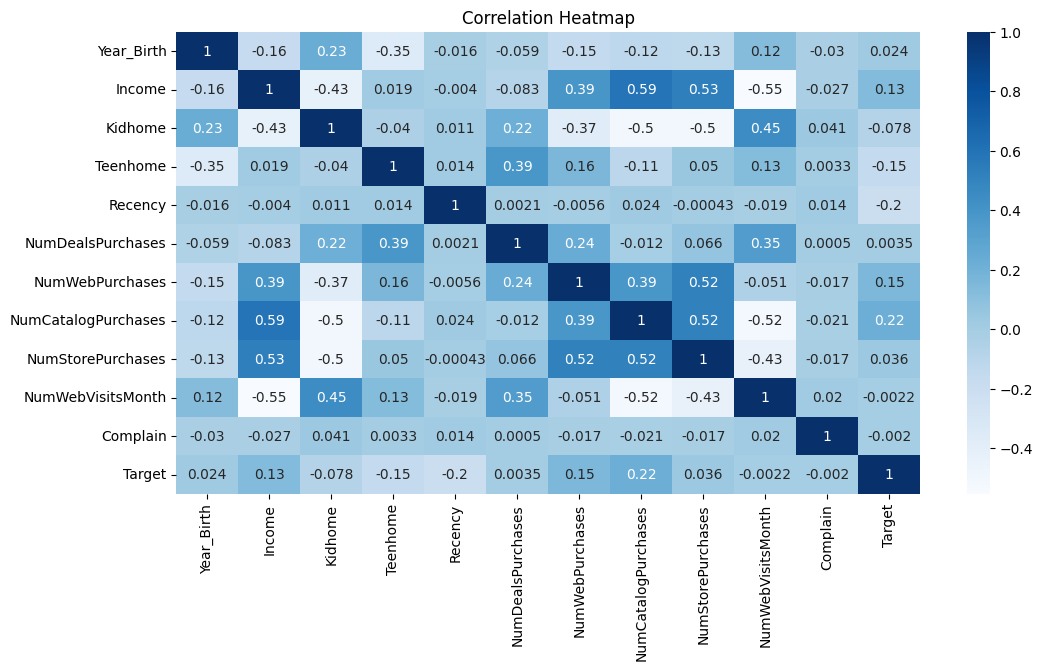

In [6]:
df_numeric = df.select_dtypes(include=["int64", "float64"])

plt.figure(figsize=(12,6))
sns.heatmap(df_numeric.corr(), annot=True, cmap="Blues")
plt.title("Correlation Heatmap")
plt.show()


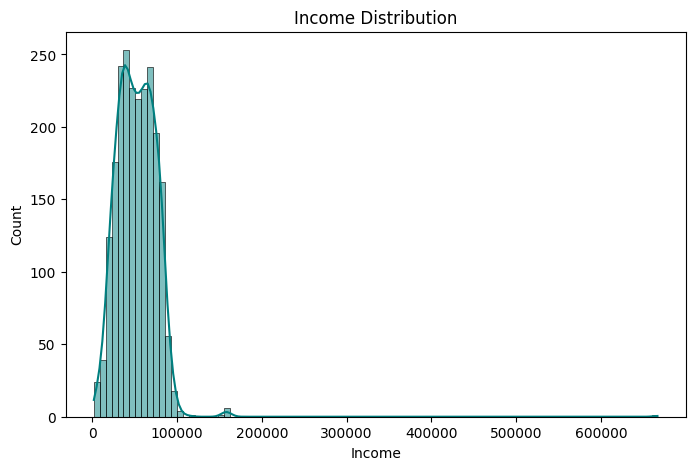

In [7]:
plt.figure(figsize=(8,5))
sns.histplot(df["Income"], kde=True, color="teal")
plt.title("Income Distribution")
plt.show()


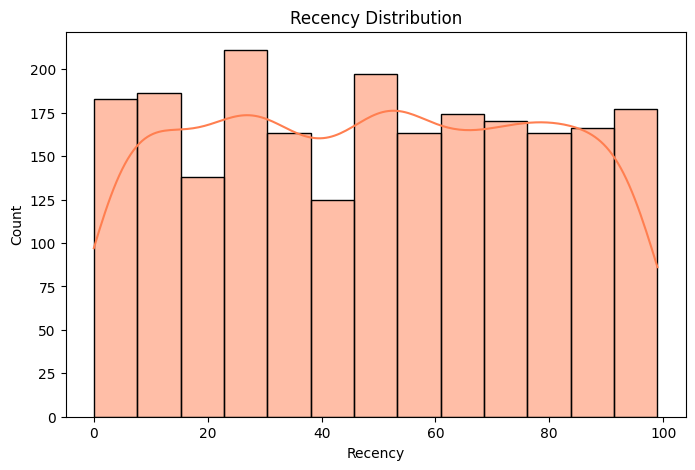

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(df["Recency"], kde=True, color="coral")
plt.title("Recency Distribution")
plt.show()


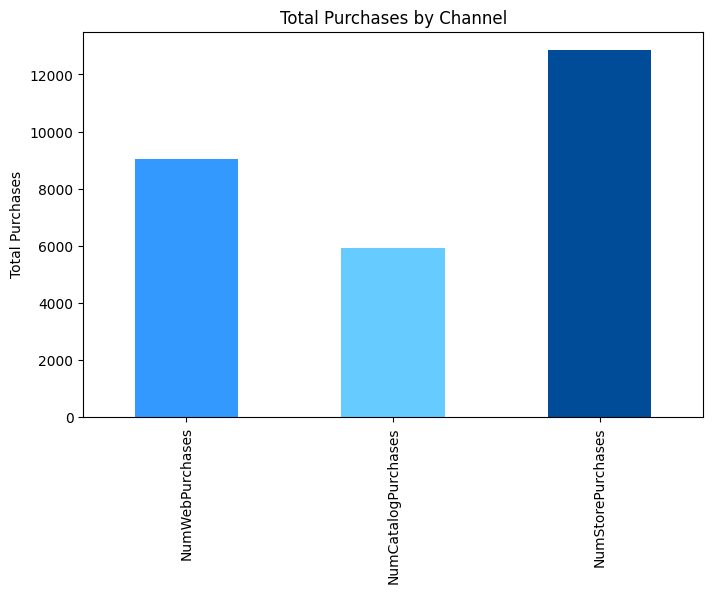

In [9]:
plt.figure(figsize=(8,5))
df[["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"]].sum().plot(kind='bar', color=["#3399ff","#66ccff","#004c99"])
plt.title("Total Purchases by Channel")
plt.ylabel("Total Purchases")
plt.show()


/var/folders/xr/fbj5qw5170ngq34kg46mb12h0000gn/T/ipykernel_77614/1249000374.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Complain", data=df, palette="Blues")


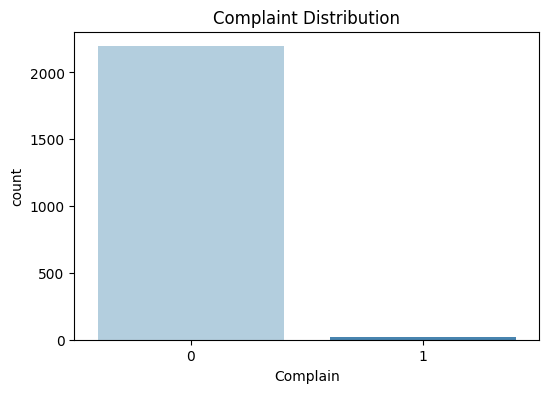

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(x="Complain", data=df, palette="Blues")
plt.title("Complaint Distribution")
plt.show()


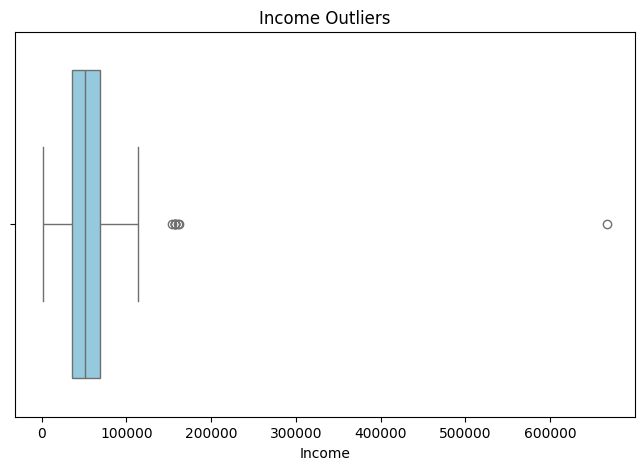

In [11]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df["Income"], color="skyblue")
plt.title("Income Outliers")
plt.show()


In [12]:
df_pos = df[df["Target"] == 1]
df_neg = df[df["Target"] == 0].sample(len(df_pos), random_state=42)

df_balanced = pd.concat([df_pos, df_neg]).sample(frac=1, random_state=42)

df_balanced["Target"].value_counts()


Target
0    333
1    333
Name: count, dtype: int64

In [13]:
X = df_balanced.drop("Target", axis=1)
y = df_balanced["Target"]

X.columns


Index(['Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Recency', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Complain'],
      dtype='object')

Model train and test

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [15]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_cols = X.select_dtypes(include=["int64","float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
    ]
)


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

results = {}

for name, model in models.items():
    pipe = Pipeline([
        ("preprocess", preprocess),
        ("model", model)
    ])

    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    acc = accuracy_score(y_test, preds)

    results[name] = acc
    print(f"{name}: {acc}")


Logistic Regression: 0.7686567164179104
Random Forest: 0.8134328358208955
SVM: 0.8059701492537313
XGBoost: 0.7686567164179104


In [17]:
import joblib

best_model_name = max(results, key=results.get)
print("Best Model:", best_model_name)

best_model = models[best_model_name]

final_model = Pipeline([
    ("preprocess", preprocess),
    ("model", best_model)
])

final_model.fit(X, y)
joblib.dump(final_model, "../model/campaign_response_model.pkl")

print("Model saved!")


Best Model: Random Forest
Model saved!


In [18]:
import os
os.listdir("../model")


['campaign_response_model.pkl']